# Importing important libraries for training

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Loading the datasets

In [2]:
train = pd.read_csv('training_data/train.csv/train.csv')
test = pd.read_csv('training_data/test.csv/test.csv')
test_y = pd.read_csv('training_data/test_labels.csv/test_labels.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.shape

(159571, 8)

In [5]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()


In [6]:
import re 
import string
import nltk
import contractions

# Data Preprocessing

In [7]:
def clean_and_preprocess_text(text):
    '''
    Takes a text, cleans it and preprocesses it
    '''
    # Lowercase the text
    text = text.lower()
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove URLs
    text = re.sub(r"https?://S+www.\.\S+", "", text)
    
    # Remove HTML tags
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    text = re.sub(html, "", text)
    
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text

train['text_clean'] = train['comment_text'].apply(lambda x: clean_and_preprocess_text(x))

### Text before and after the data cleaning

In [8]:
print(train['comment_text'][1])
print(train['text_clean'][1])

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
daww he matches this background colour i am seemingly stuck with thanks  talk 2151 january 11 2016 utc


## Importing data preprocessing Libraries

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train['text_clean'], train_labels, test_size= 0.3)

### Vectorization of the training file

In [11]:

vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32) # Initialize the Tensorflow Vectorizer 

In [12]:
# Word ngram vector
tr_vect = vect_word.fit_transform(X_train)
ts_vect = vect_word.transform(X_test)

ts_vect_array = ts_vect.toarray()
tr_vect_array = tr_vect.toarray()
tr_vect_array = tr_vect_array.reshape(tr_vect_array.shape[0], 1, tr_vect_array.shape[1])
ts_vect_array = ts_vect_array.reshape(ts_vect_array.shape[0], 1, ts_vect_array.shape[1])




In [93]:
import pickle
with open("trained_vectorizer.pkl", "wb") as f:
    pickle.dump(vect_word, f)

In [13]:
type(tr_vect_array)

numpy.ndarray

In [14]:
ts_vect_array.shape

(47872, 1, 20000)

In [15]:
input_shape = tr_vect_array.shape[1:]
input_shape


(1, 20000)

# Model Training

## Importing libraries for creating a model

In [16]:
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPooling1D, Dropout, GRU

In [115]:
def get_model():
  '''
  Creates and returns the Bidirectional LSTM model 
  '''
  model = Sequential()
  model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.1))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(6, activation='sigmoid'))

# compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

#### Model Parameters

In [128]:
model = get_model()
batch_size = 128
epochs = 10

## Experimentation Tracking

In [117]:
from keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)



#### Using Early Stopping

In [129]:
from keras.callbacks import EarlyStopping

early = EarlyStopping(monitor='val_loss', mode='min', patience=5)

callbacks_list = [early]

In [130]:
with tf.device('/CPU:0'):
    
    history = model.fit(tr_vect_array, y_train, batch_size=batch_size, epochs=epochs,validation_data=(ts_vect_array, y_test), callbacks=callbacks_list)

Epoch 1/10
873/873 [==============================] - 90s 98ms/step - loss: 0.0873 - accuracy: 0.9545 - val_loss: 0.0577 - val_accuracy: 0.9942
Epoch 2/10
873/873 [==============================] - 76s 87ms/step - loss: 0.0482 - accuracy: 0.9811 - val_loss: 0.0571 - val_accuracy: 0.9808
Epoch 3/10
873/873 [==============================] - 74s 85ms/step - loss: 0.0397 - accuracy: 0.9262 - val_loss: 0.0602 - val_accuracy: 0.8931
Epoch 4/10
873/873 [==============================] - 75s 86ms/step - loss: 0.0327 - accuracy: 0.8371 - val_loss: 0.0663 - val_accuracy: 0.8325
Epoch 5/10
873/873 [==============================] - 77s 89ms/step - loss: 0.0268 - accuracy: 0.8087 - val_loss: 0.0751 - val_accuracy: 0.7681
Epoch 6/10
873/873 [==============================] - 76s 87ms/step - loss: 0.0225 - accuracy: 0.7625 - val_loss: 0.0851 - val_accuracy: 0.7994
Epoch 7/10
873/873 [==============================] - 87s 100ms/step - loss: 0.0187 - accuracy: 0.7045 - val_loss: 0.0990 - val_accuracy

In [131]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 1, 256)           20612096  
 nal)                                                            
                                                                 
 global_max_pooling1d_8 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 6)                

In [132]:
model.save("model3.h5")

In [133]:
history.history

{'loss': [0.08730953186750412,
  0.04822378233075142,
  0.039702314883470535,
  0.03268115222454071,
  0.02679930254817009,
  0.022495519369840622,
  0.018736129626631737],
 'accuracy': [0.9544848203659058,
  0.9810920357704163,
  0.9261586666107178,
  0.837088942527771,
  0.8086553812026978,
  0.7625314593315125,
  0.7045273184776306],
 'val_loss': [0.05766666680574417,
  0.05710441246628761,
  0.060219962149858475,
  0.06631292402744293,
  0.07514585554599762,
  0.08509107679128647,
  0.09903484582901001],
 'val_accuracy': [0.9941928386688232,
  0.9807820916175842,
  0.8930690288543701,
  0.8324699401855469,
  0.7680690288543701,
  0.7994025945663452,
  0.6395596861839294]}

In [134]:
import matplotlib.pyplot as plt

In [135]:
with tf.device('/CPU:0'):
    loss, accuracy = model.evaluate(ts_vect_array, y_test)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)

1496/1496 [==============================] - 24s 16ms/step - loss: 0.0990 - accuracy: 0.6396
Test loss: 0.0990348756313324
Test accuracy: 0.6395596861839294


In [136]:
with tf.device('/CPU:0'):
    y_pred = model.predict(ts_vect_array)

1496/1496 [==============================] - 24s 15ms/step


In [137]:
with tf.device('/CPU:0'):
    y_pred_binary = (y_pred > 0.5).astype(int)

In [138]:
print(y_pred_binary)

[[0 0 0 0 0 0]
 [1 0 1 0 1 0]
 [1 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [139]:
from keras.models import load_model


In [151]:
model = load_model("model3.h5")

input_text = "You are so beautiful"

# Preprocess the new text data
new_text = clean_and_preprocess_text(input_text)

# Transform the new text data using the same vectorizer object
new_text_vect = vect_word.transform([new_text])

# Reshape the transformed data into the required input shape
new_text_vect_array = new_text_vect.toarray().reshape(1, 1, -1)

# Get predictions for the new text data
predictions = model.predict(new_text_vect_array)

1/1 [==============================] - 1s 731ms/step


In [152]:
predictions

array([[7.1113740e-05, 1.2729292e-07, 4.4404774e-06, 1.9408808e-10,
        3.0457652e-08, 1.6223366e-08]], dtype=float32)

In [153]:
predictions = predictions[0]

In [112]:
train_labels

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [154]:
import matplotlib.pyplot as plt

def plot_probabilities(prob_dict):
    # Sort the dictionary in descending order of values
    sorted_prob_dict = {k: v for k, v in sorted(prob_dict.items(), key=lambda item: item[1], reverse=True)}
    
    # Create lists of labels and their corresponding probabilities
    labels = list(sorted_prob_dict.keys())
    probabilities = list(sorted_prob_dict.values())
 
    # Set up the bar graph
    plt.bar(labels, probabilities, color='brown')
    
    # Set the y-axis limits to 0 and 1
    plt.ylim(0, 1)
    
    # Set the x- and y-axis labels
    plt.xlabel('Label')
    plt.ylabel('Probability')
    
    # Set the title of the plot
    plt.title(f'Label Probabilities of {input_text}')
    
    # Show the plot
    plt.show()

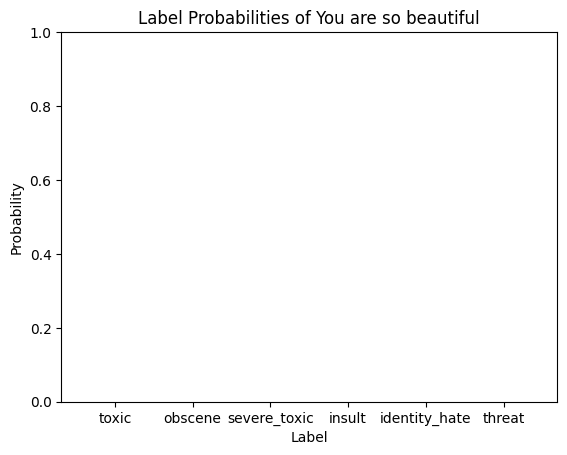

In [155]:
a = {
    'toxic':predictions[0],	'severe_toxic':predictions[1],	'obscene':predictions[2],	'threat':predictions[3],'insult':predictions[4],	'identity_hate':predictions[5]
    }
plot_probabilities(a)